In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
import Q2Q1FEM
import PolyFEM
import pandas as pd 
import itertools
from copy import deepcopy
import amplify
from amplify import BinaryPoly, gen_symbols,sum_poly, decode_solution
from amplify import Solver
from amplify.client import FixstarsClient
token = "AE/tAR7MLHq3WTe0DSGFyDWdcwHm4eKoIxN "
import time

In [44]:
nelm = 16
Node,Element,NodeBC=Q2Q1FEM.SquareMeshQ2(nelm)
Node_P,Element_P,NodeBC_P=Q2Q1FEM.SquareMeshQ1(nelm)  #Don't use NodeBC_P!!!!!(NodeBC_P contains the value of the velocity🥶)
fem_NElem = Element.shape[0]
zIni = np.ones(fem_NElem)

In [45]:
adj_elem_list = []
for i in range(nelm*nelm):
    t_adj = []
    if i%nelm!=0:
        t_u = i-1
        t_adj.append(t_u)
    if i>=nelm:
        t_l = i-nelm
        t_adj.append(t_l)
    if i%nelm!=nelm-1:
        t_o = i+1
        t_adj.append(t_o)
    if (nelm*nelm)-i>nelm:
        t_r = i+nelm
        t_adj.append(t_r)
    adj_elem_list.append(t_adj)
for i in range(nelm*nelm*2):
    j = i+nelm**2
    t_adj = []
    if i%(2*nelm)!=0:
        t_u = j-1
        t_adj.append(t_u)
    if i<nelm:
        t_l = j-nelm
        t_adj.append(t_l)
    elif i>=2*nelm:
        t_l = j-2*nelm
        t_adj.append(t_l)
    if i%(2*nelm)!=2*nelm-1:
        t_o = j+1
        t_adj.append(t_o)
    if i<(nelm-1)*nelm*2:
        t_r = j+2*nelm
        t_adj.append(t_r)
    adj_elem_list.append(t_adj)

In [53]:
def Construct_QUBO(Nelm,u,v,volfrac,num_bit_per,xc):
    ## bit string
    v_limited = volfrac*Nelm

    ## coef for porous resistivity
    coef_pr = 10**5/4
    coef_pr_pres = [0 for _ in range(Nelm)]

    ## coef for energy loss, eqn constraint, gradient energy, heviside function, boundary constraint, domain constraints
    alpha_el = 5
    alpha_eqn_c = 1
    alpha_ge = 10.0
    alpha_hev = 300.0
    alpha_bc = 1.0
    alpha_dc = 600.0

    ## qubit
    q = gen_symbols(BinaryPoly,Nelm,num_bit_per+1)

    ## objective function
    obj_func = BinaryPoly()

    ### energy loss
    for t_id in range(Nelm):
        coef_pr_e = (1-q[t_id][-1])*coef_pr
        t_uvec = u[t_id]/xc*2
        t_vvec = v[t_id]/xc*2
        obj_func += alpha_el*(coef_pr_e*(t_uvec*t_uvec+t_vvec*t_vvec) )

    ### gradient energy
    for t_id,t_q in enumerate(q):
        for tt_id in adj_elem_list[t_id]:
            phi_i = (sum_poly(t_q[:-1])/num_bit_per*2)-1
            phi_j = (sum_poly(q[tt_id][:-1])/num_bit_per*2)-1
            obj_func += alpha_ge/2*(phi_i-phi_j)**2

    ### boundary constraint
    # for t_id, t_q in enumerate(q):
    #     if t_id in in_bound_element+out_bound_element:
    #         obj_func += alpha_bc*((sum_poly(t_q[:-1])/num_bit_per*2)-1 -1)**2
    #     else:
    #         pass

    ### heviside function
    for t_id, t_q in enumerate(q):
        obj_func += alpha_hev*(sum_poly(t_q[:-1])/num_bit_per - t_q[-1])**2

    ### domaint constraints
    obj_func += alpha_dc*(sum_poly([t[-1] for t in q]) - v_limited)**2
    
    client = FixstarsClient()
    client.parameters.timeout = 10000   # タイムアウト X m秒
    client.token = token # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください
    #client.parameters.outputs.duplicate = True  # 同じエネルギー値の解を列挙するオプション（解が複数個あるため）

    solver = Solver(client)
    solver.sort_solution = False # 解をエネルギー順にソートしない
    solver.client.parameters.outputs.sort = False # 解をエネルギー順にソートしない
    solver.client.parameters.outputs.num_outputs = 0 # エネルギーの更新ごとに得られたすべての解をsolutionsに含める
    d = {"sampling_time":[],"energy":[]} #履歴データを格納する
    result = solver.solve(obj_func)
    for t, s in zip(solver.client_result.timing.time_stamps, result.solutions):
        if s.is_feasible:
            d["sampling_time"].append(t)
            d["energy"].append(s.energy)
    number=solver.client_result.execution_parameters.num_iterations
    print("Solved",flush=True)
    print(number)
    
    solution =[]
    for i in range(len(d["energy"])):
        solution.append( decode_solution(q, result[i].values))
    
    return solution,d

In [54]:
num_bit_per = 9
p,f,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,zIni)
solution, hist = Construct_QUBO(fem_NElem,u,v,volfrac=0.75,num_bit_per=num_bit_per,xc=2)

Solved
17


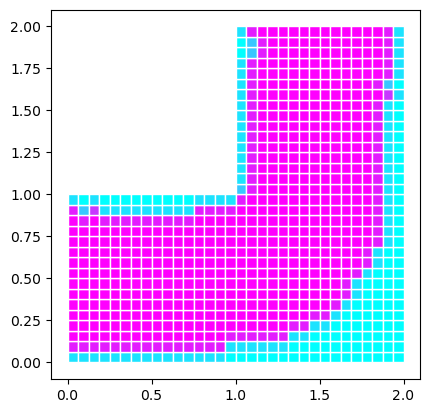

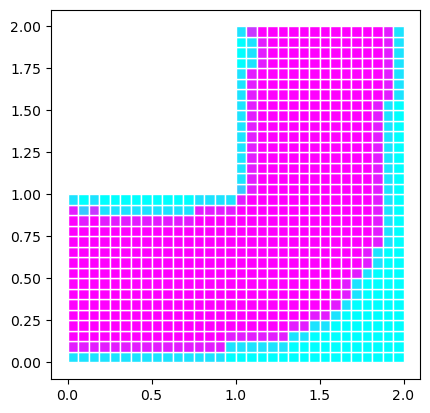

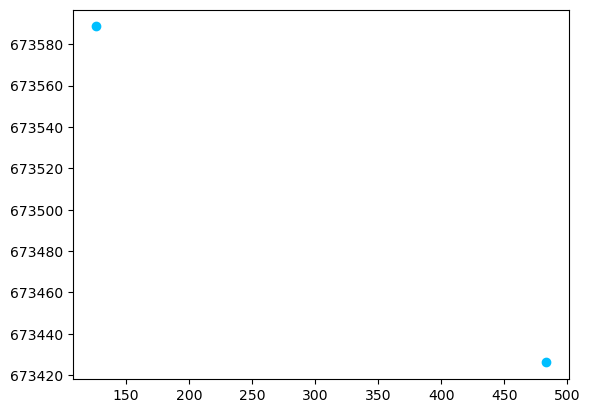

In [55]:
num = len(solution)
for i in range(num):
    phi_sol=solution[i]
    phi=[]
    for t in phi_sol:
        pred_t_d = np.sum(t[:-1])/num_bit_per
        phi.append(pred_t_d)
        z_QA = np.array(phi)
    Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z_QA,1,0,cmap='cool')

time=hist['sampling_time']
energy=hist['energy']
plt.plot(time,energy,linestyle='None', marker='o',color='deepskyblue')

--- 1th iteration ---
Solved
16


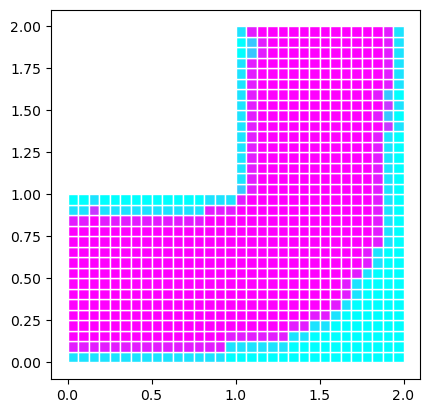

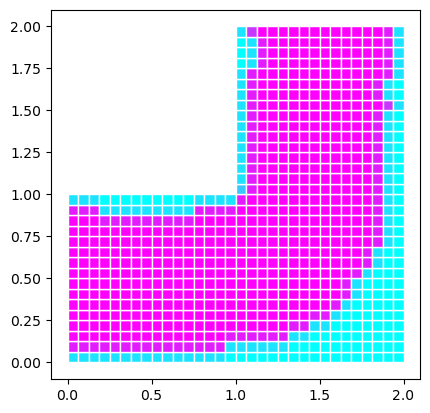

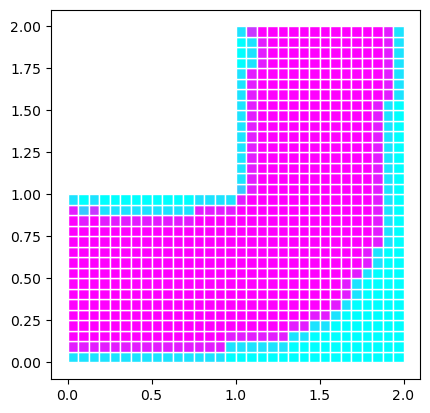

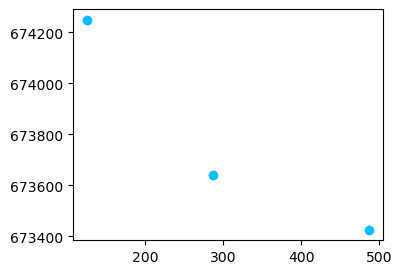

--- 2th iteration ---
Solved
16


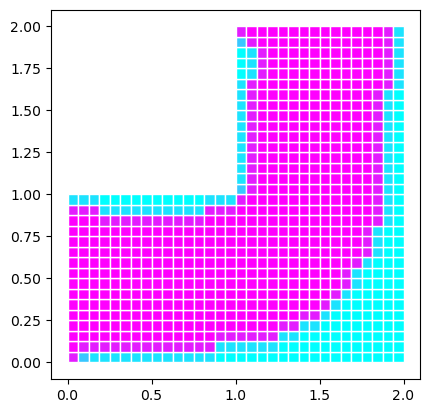

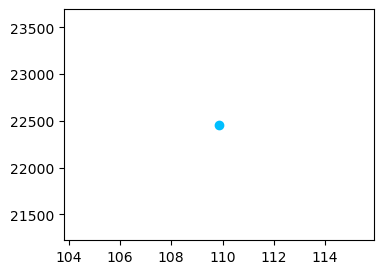

--- 3th iteration ---
Solved
14


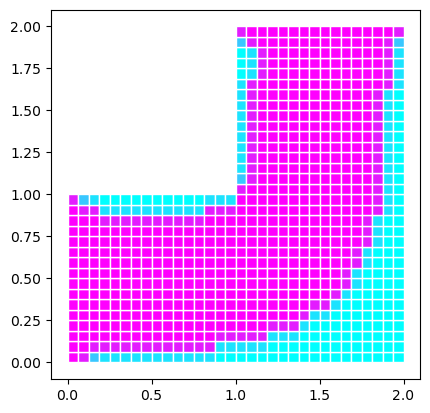

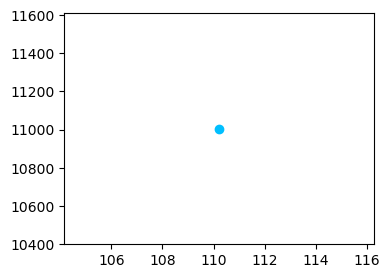

--- 4th iteration ---
Solved
16


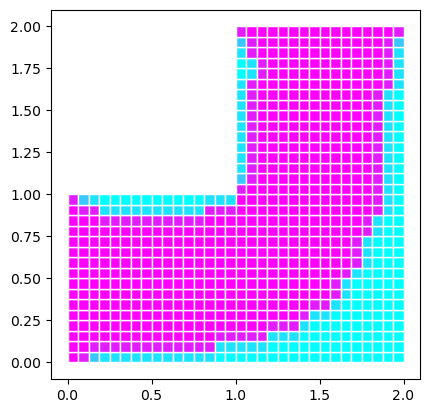

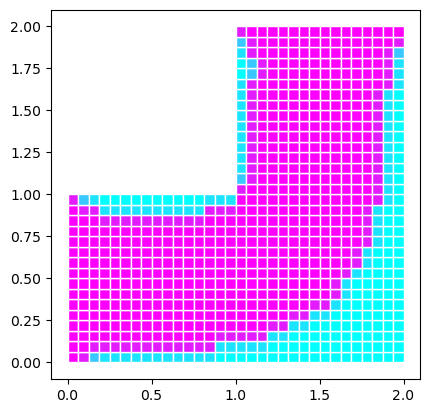

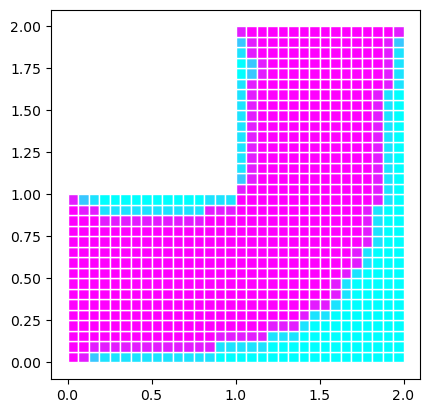

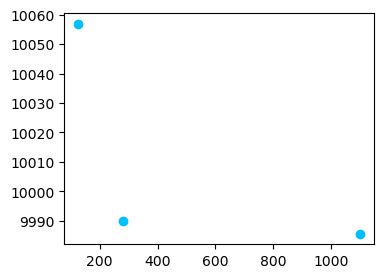

--- 5th iteration ---
Solved
15


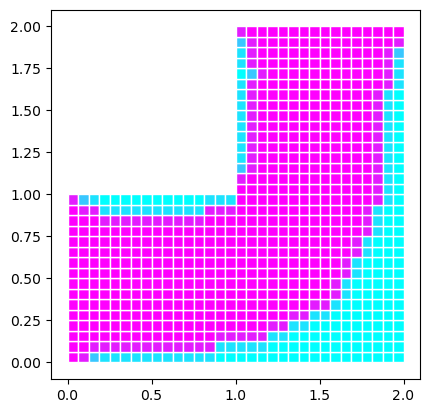

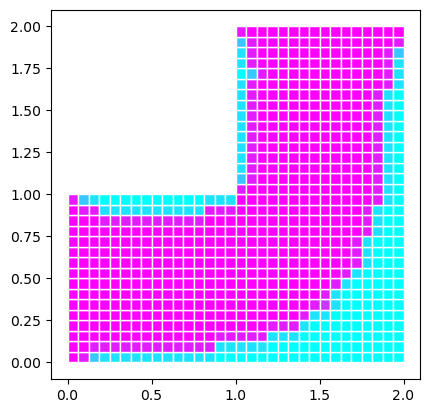

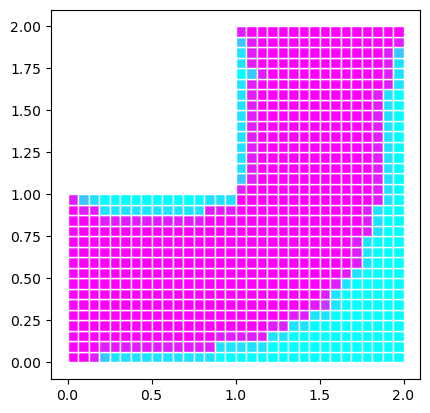

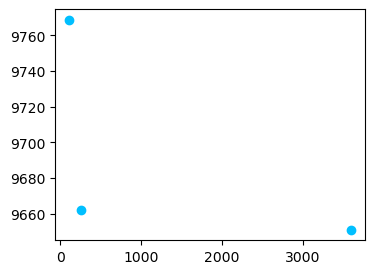

--- 6th iteration ---
Solved
15


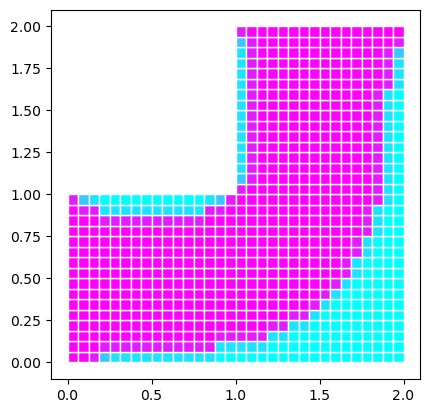

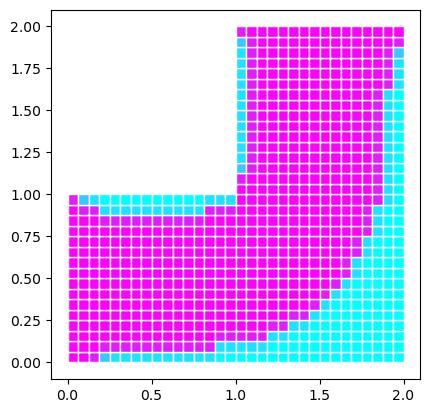

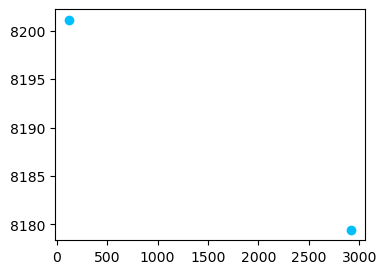

--- 7th iteration ---
Solved
16


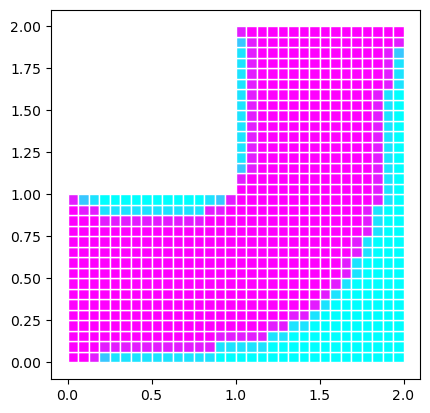

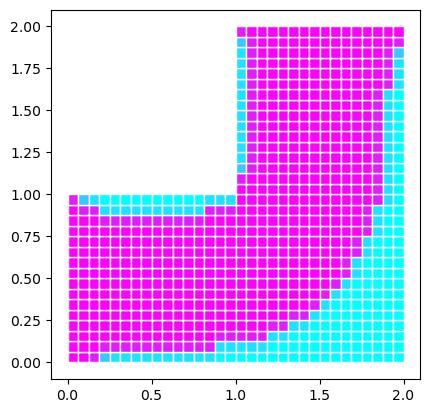

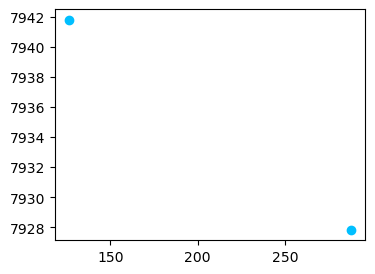

In [56]:
z_QA_new = zIni
maxiter = 15
p,f,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,zIni)
for i in range(maxiter):
    print('--- {}th iteration ---'.format(i+1))
    if i==0:
        xc = 2
    else:
        xc = max(np.sqrt(u**2+v**2))
    z_QA = z_QA_new
    solution,hist = Construct_QUBO(fem_NElem,u,v,volfrac=0.75,num_bit_per=num_bit_per,xc=xc)
    num = len(solution)
    for j in range(num):
        phi_sol=solution[j]
        phi=[]
        for t in phi_sol:
            pred_t_d = np.sum(t[:-1])/num_bit_per
            phi.append(pred_t_d)
            z_QA_new = np.array(phi)
        Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z_QA_new,1,0,cmap='cool')
    time=hist['sampling_time']
    energy=hist['energy']
    plt.figure(figsize=(4,3))
    plt.plot(time,energy,linestyle='None', marker='o',color='deepskyblue')
    plt.show()
    p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z_QA_new) #original
    if np.max(np.abs(z_QA-z_QA_new))<0.01:
        break